# Import libraries

In [1]:
# General libraries
import gc
import geopandas
import json
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric import seed_everything
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn.conv import *

# GraphToolbox
from graphtoolbox.data.dataset import *
from graphtoolbox.interpretability.explain import *
from graphtoolbox.models.gnn import *
from graphtoolbox.optim.optimizer import *
from graphtoolbox.training.metrics import *
from graphtoolbox.training.trainer import Trainer
from graphtoolbox.utils.attention import *
from graphtoolbox.utils.helper_functions import *
from graphtoolbox.utils.visualizations import *

In [2]:
DF_VILLES = pd.DataFrame(
    {'VILLE': ['LILLE', 'ROUEN', 'PARIS', 'STRASBOURG', 'BREST', 'NANTES', 'ORLEANS', 'DIJON', 'BORDEAUX', 'LYON',
              'TOULOUSE', 'MARSEILLE'],
    'LATITUDE': [50.6365654, 49.4404591, 48.862725, 48.584614, 
                 48.3905283, 47.2186371, 47.9027336, 47.3215806, 
                 44.841225, 45.7578137, 43.6044622, 43.2961743],
    'LONGITUDE': [3.0635282, 1.0939658, 2.287592, 7.7507127, 
                  -4.4860088, -1.5541362, 1.9086066, 5.0414701, 
                  -0.5800364, 4.8320114, 1.4442469, 5.3699525],
    'REGION': ['Hauts_de_France', 'Normandie', 'Ile_de_France', 'Grand_Est', 'Bretagne', 'Pays_de_la_Loire', 
                'Centre_Val_de_Loire', 'Bourgogne_Franche_Comte', 'Nouvelle_Aquitaine', 'Auvergne_Rhone_Alpes', 
                'Occitanie', 'Provence_Alpes_Cote_d_Azur'],
    'SUPERFICIE_REGION': [31813, 29906, 12011, 57433, 27208, 32082, 39151, 47784, 83809, 69711, 72724, 31400],
    'POPULATION_REGION': [5987172, 3307286, 12395148, 5542094, 3402932, 3873096, 2564915, 2785393, 6081985,
                          8153233, 6053548, 5131187]
    }
).sort_values(by='REGION').reset_index(drop=True)

GDF_VILLES = geopandas.GeoDataFrame(
    DF_VILLES,
    geometry=geopandas.points_from_xy(DF_VILLES.LONGITUDE, DF_VILLES.LATITUDE)
).set_crs("EPSG:4326")

# Import data

In [3]:
### GLOBAL VARIABLES
DATASET = 'rfrance' # 'rfrance', 'weave'
TRAIN = True
OUT_CHANNELS = 48
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
seed_everything(42)

In [4]:
if DATASET == 'weave':
    print("Weave Dataset")
    data_kwargs = {
        'node_var': 'id_unique',
        'dummies': ['instant', 'id_uniqueInt',],
        'day_inf_train': '2024-02-13',
        'day_sup_train': '2024-02-23',
        'day_inf_val': '2024-02-23',
        'day_sup_val': '2024-02-25',
        'day_inf_test': '2024-02-25',
        'day_sup_test': '2024-02-29'
    }

    dataset_kwargs = {
        'adj_matrix': 'dtw',
        'features_base': ['instant', 'id_uniqueInt', 'weekday'] + [f'consumption_l{t}' for t in range(1, 48+1)],
        'target_base': 'consumption',
    }

    nrows, ncols = 4, 7

    data = DataClass(path_train='./data/weave/train_weave.csv', 
                    path_test='./data/weave/test_weave.csv', 
                    data_kwargs=data_kwargs,
                    folder_config='.')

    graph_dataset_train = GraphDataset(data=data, period='train', 
                                    graph_folder='./graph_representations_weave',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=OUT_CHANNELS)
    graph_dataset_val = GraphDataset(data=data, period='val', 
                                    scalers_feat=graph_dataset_train.scalers_feat, 
                                    scalers_target=graph_dataset_train.scalers_target,
                                    graph_folder='./graph_representations_weave',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=OUT_CHANNELS)
    graph_dataset_test = GraphDataset(data=data, period='test',
                                    scalers_feat=graph_dataset_train.scalers_feat, 
                                    scalers_target=graph_dataset_train.scalers_target,
                                    graph_folder='./graph_representations_weave',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=OUT_CHANNELS)
else:    
    print("Regional French Dataset")
    data_kwargs = {
        'node_var': 'Region',
        'dummies': ['Instant', 'JourSemaine', 'DayType', 'offset'],
        'day_inf_train': '2015-01-01',
        'day_sup_train': '2018-01-01',
        'day_inf_val': '2018-01-01',
        'day_sup_val': '2018-12-31',
        'day_inf_test': '2019-01-01',
        'day_sup_test': '2019-12-31'
    }

    dataset_kwargs = {
        'adj_matrix': 'dtw',
        'features_base': ['temp', 'nebu', 'wind', 'tempMax', 'tempMin', 'Posan', 'Instant', 'JourSemaine', 'JourFerie', 'offset', 'DayType', 'Weekend', 'temp_liss_fort', 'temp_liss_faible'] + [f'load_l{t}' for t in range(1, 48+1)],
        'target_base': 'load',
    }

    nrows, ncols = 3, 4

    data = DataClass(path_train='./data/rfrance/train2.csv', 
                    path_test='./data/rfrance/test2.csv', 
                    data_kwargs=data_kwargs,
                    folder_config='.')

    graph_dataset_train = GraphDataset(data=data, period='train', 
                                      graph_folder='./graph_representations_rfrance',
                                      dataset_kwargs=dataset_kwargs,
                                      out_channels=OUT_CHANNELS)
    graph_dataset_val = GraphDataset(data=data, period='val', 
                                     scalers_feat=graph_dataset_train.scalers_feat, 
                                     scalers_target=graph_dataset_train.scalers_target,
                                     graph_folder='./graph_representations_rfrance',
                                     dataset_kwargs=dataset_kwargs,
                                     out_channels=OUT_CHANNELS)
    graph_dataset_test = GraphDataset(data=data, period='test',
                                      scalers_feat=graph_dataset_train.scalers_feat, 
                                      scalers_target=graph_dataset_train.scalers_target,
                                      graph_folder='./graph_representations_rfrance',
                                      dataset_kwargs=dataset_kwargs,
                                      out_channels=OUT_CHANNELS)

Regional French Dataset


In [6]:
# Load configs where each top-level key is the conv name
config_path = f'configs/config_{DATASET}.json'
if not os.path.isfile(config_path):
    raise FileNotFoundError(f"Config file not found: {config_path}")

_CONV_MAP = {
    'GCNConv': GCNConv,
    'GATConv': GATConv,
    'GATv2Conv': GATv2Conv,
    'TransformerConv': TransformerConv,
    'TAGConv': TAGConv,
    'ChebConv': ChebConv,
    'APPNP': APPNP,
    'GraphSAGE': GraphSAGE,
}

with open(config_path, 'r') as f:
    raw = json.load(f)

# Build CONFIGS from the new JSON shape
SELECTED_MODELS = ['GATConv']
_selection = globals().get('SELECTED_MODELS', None)
if isinstance(_selection, str):
    _selection = [s.strip() for s in _selection.split(',') if s.strip()]

available_models = list(raw.keys())
to_keep = available_models if not _selection else [m for m in _selection if m in raw]

if _selection:
    unknown = [m for m in _selection if m not in raw]
    if unknown:
        print(f"Warning: unknown model(s) ignored: {unknown}. Available: {available_models}")

CONFIGS = {}
for model_name in to_keep:
    conf = raw[model_name]
    conv_key = conf.get('conv', model_name)  # utilise la clé si 'conv' absent

    if isinstance(conv_key, str):
        if conv_key not in _CONV_MAP:
            raise KeyError(f"Unknown conv '{conv_key}' for model '{model_name}'. "
                           f"Available convs: {list(_CONV_MAP.keys())}")
        conv_cls = _CONV_MAP[conv_key]
    else:
        conv_cls = conv_key

    CONFIGS[model_name] = {
        'adj_matrix': conf['adj_matrix'],
        'conv': conv_cls,
        'params': conf['params'],
    }

print(f"Loaded CONFIGS from {config_path}: {list(CONFIGS.keys())}")

results = []
models = {}
preds = {}
N = 1  # Number of runs per model
os.makedirs(f"interpretability_{DATASET}", exist_ok=True)

if TRAIN:
    for model_name, cfg in CONFIGS.items():
        conv_class = cfg["conv"]
        adj_matrix = cfg["adj_matrix"]
        graph_dataset_train._set_adj_matrix(adj_matrix=adj_matrix)
        graph_dataset_val._set_adj_matrix(adj_matrix=adj_matrix)
        graph_dataset_test._set_adj_matrix(adj_matrix=adj_matrix)

        params = cfg["params"]
        results_rmse, results_mape = [], []

        for i in range(N):
            print(f"\n--- {model_name} | Run {i+1}/{N} ---")
            gc.collect()
            torch.cuda.empty_cache()

            conv_kwargs = {}
            for k in ["heads", "K", "alpha"]:
                if k in params:
                    conv_kwargs[k] = params[k]

            if conv_class is not GraphSAGE:
                model = myGNN(
                    in_channels=graph_dataset_train.num_node_features,
                    num_layers=params["num_layers"],
                    hidden_channels=params["hidden_channels"],
                    out_channels=OUT_CHANNELS,
                    conv_class=conv_class,
                    conv_kwargs=conv_kwargs
                )
            else:
                model = myGNN(
                    in_channels=graph_dataset_train.num_node_features,
                    num_layers=params["num_layers"],
                    hidden_channels=params["hidden_channels"],
                    out_channels=OUT_CHANNELS,
                    conv_class=SAGEConv,
                    conv_kwargs=conv_kwargs | {'project': True}
                )
            trainer = Trainer(
                model=model,
                dataset_train=graph_dataset_train,
                dataset_val=graph_dataset_val,
                dataset_test=graph_dataset_test,
                batch_size=params["batch_size"],
                return_attention=True,
                model_kwargs={'lr': params["lr"], 'num_epochs': 30},
                lam_reg=0
            )

            pred_model_test, target_test, edge_index, attention_weights = trainer.train(
                plot_loss=False,
                force_training=True,
                save=True,
                patience=300
            )

            models[f"{model_name}_run{i}"] = model.state_dict()

            preds[f"{model_name}_run{i}"] = {
                "predictions": pred_model_test,
            }

            rmse = RMSE(preds=pred_model_test.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
            results_rmse.append(rmse)
            mape = MAPE(preds=pred_model_test.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
            results_mape.append(mape)

        results.append({
            "model": model_name,
            "min_rmse": np.min(results_rmse),
            "mean_rmse": np.mean(results_rmse),
            "max_rmse": np.max(results_rmse),
            "std_rmse": np.std(results_rmse),
            "min_mape": np.min(results_mape),
            "mean_mape": np.mean(results_mape),
            "max_mape": np.max(results_mape),
            "std_mape": np.std(results_mape)
        })  
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='mean_rmse')
    # average predictions over runs for each model
    for model_name in CONFIGS.keys():
        all_runs = [preds[f"{model_name}_run{i}"]["predictions"] for i in range(N)]
        avg_pred = torch.mean(torch.stack(all_runs), dim=0)
        preds[f"{model_name}_avg"] = {
            "predictions": avg_pred,
        }

    # compute metrics for averaged predictions
    for model_name in CONFIGS.keys():
        avg_pred = preds[f"{model_name}_avg"]["predictions"]
        rmse = RMSE(preds=avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
        mape = 100*MAPE(preds=avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
        print(f"{model_name} | Averaged Predictions | RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

    # average predictions over all models
    all_model_preds = [preds[f"{model_name}_avg"]["predictions"] for model_name in CONFIGS.keys()]
    final_avg_pred = torch.mean(torch.stack(all_model_preds), dim=0)
    final_rmse = RMSE(preds=final_avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
    final_mape = 100*MAPE(preds=final_avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
    print(f"All Models Averaged Predictions | RMSE: {final_rmse:.4f}, MAPE: {final_mape:.4f}")


Loaded CONFIGS from configs/config_rfrance.json: ['GATConv']

--- GATConv | Run 1/1 ---
Training model...


100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


GATConv | Averaged Predictions | RMSE: 2253.5315, MAPE: 3.6091
All Models Averaged Predictions | RMSE: 2253.5315, MAPE: 3.6091


In [7]:
name = CONFIGS.keys().__iter__().__next__()
conv_class = CONFIGS[name]['conv']
adj_matrix = CONFIGS[name]['adj_matrix']
batch_size = CONFIGS[name]['params']['batch_size']
hidden_channels = CONFIGS[name]['params']['hidden_channels']
num_layers = CONFIGS[name]['params']['num_layers']
num_epochs = 30
heads = CONFIGS[name]['params'].get('heads', 1)
all_attn, edge_idx = load_attention_batches(f"attention_matrix/{conv_class.__name__}_{adj_matrix}/test_batch{batch_size}_hidden{hidden_channels}_layers{num_layers}_epochs{num_epochs}_heads{heads}")   # [L,H,G,E_graph], edge_idx [2,E_graph]
glob = pca_global_mean(all_attn, edge_idx, num_nodes=graph_dataset_test.num_nodes, n_components=6)

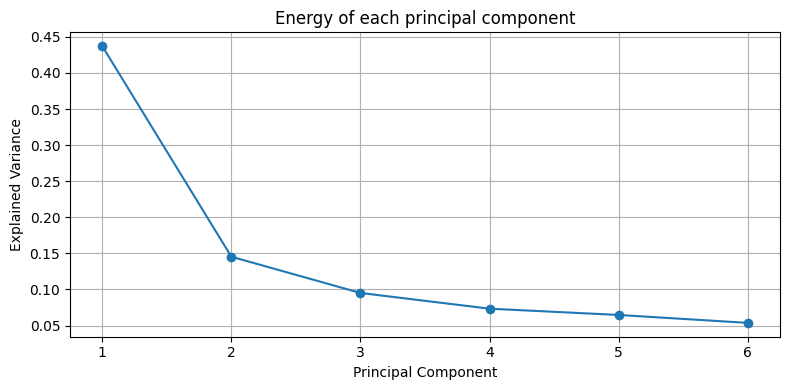

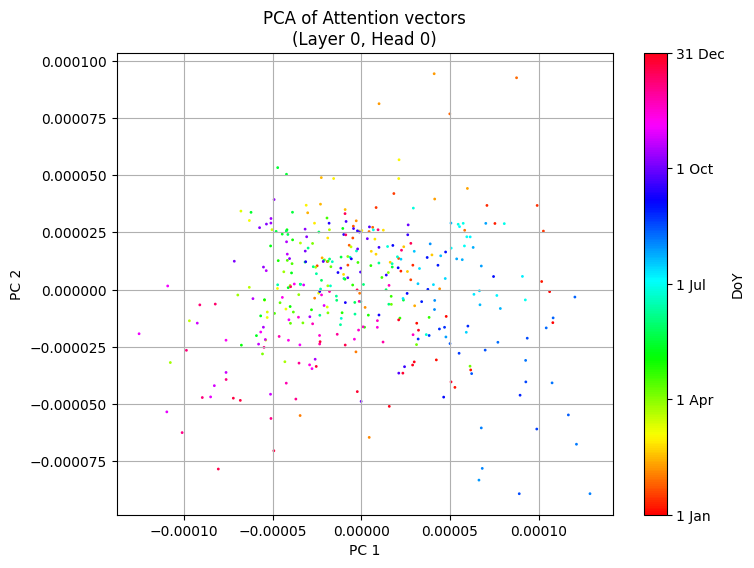

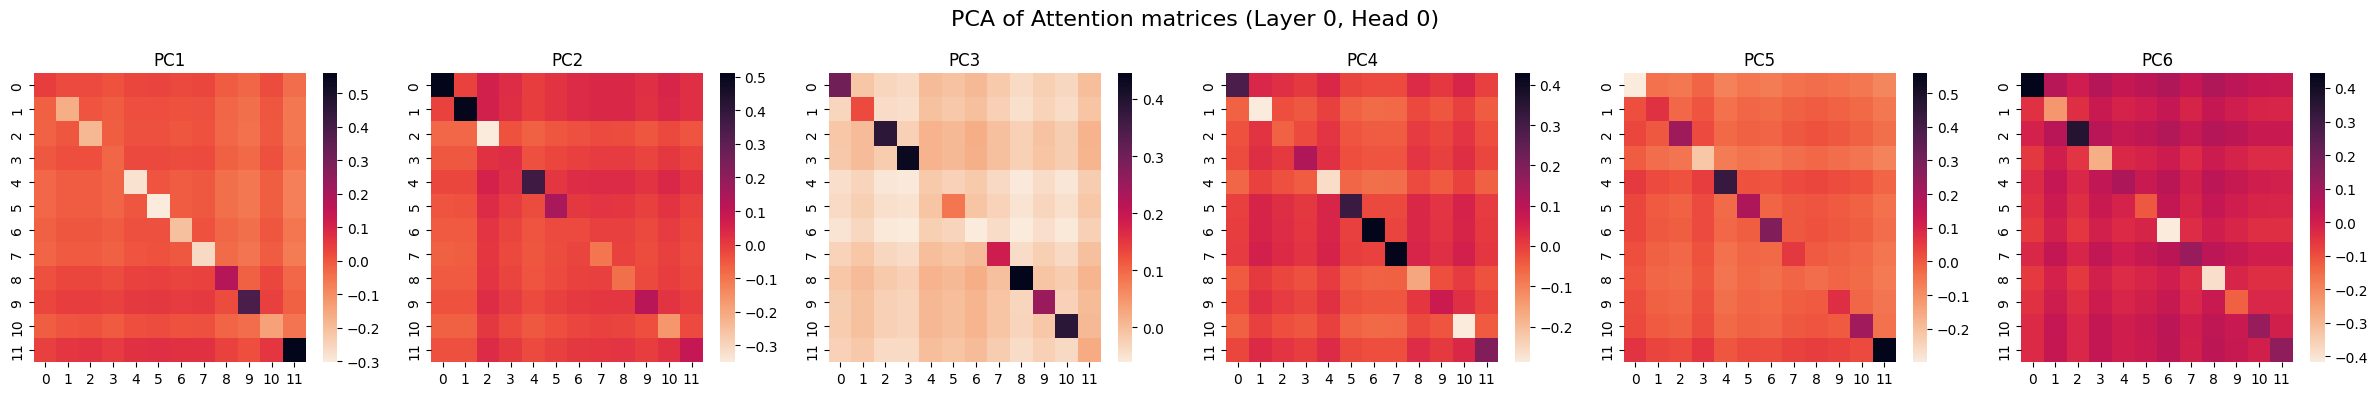

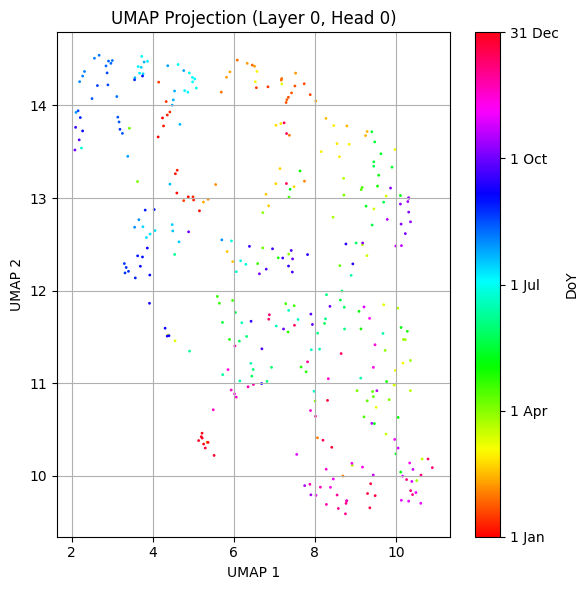

In [8]:
layer_idx, head_idx = 0,0
colors = np.linspace(0, 1, glob["scores"].shape[0])
pca_analysis_attention(
    all_attentions=all_attn,
    edge_index=edge_idx,
    layer_idx=layer_idx,
    head_idx=head_idx,
    n_components=6
)
umap_analysis_attention(
    all_attentions=all_attn, 
    edge_index=edge_idx, 
    layer_idx=layer_idx, 
    head_idx=head_idx
)

## Explainer (GNNExplainer)

In [10]:
all_explanations = {}
for model_name, cfg in CONFIGS.items():
    conv_class = cfg["conv"]
    adj_matrix = cfg["adj_matrix"]
    graph_dataset_train._set_adj_matrix(adj_matrix=adj_matrix)
    graph_dataset_val._set_adj_matrix(adj_matrix=adj_matrix)
    graph_dataset_test._set_adj_matrix(adj_matrix=adj_matrix)

    params = cfg["params"]
    print(f"\n--- Explaining {model_name} ---")
    if conv_class is not GraphSAGE:
        model = myGNN(
            in_channels=graph_dataset_train.num_node_features,
            num_layers=params["num_layers"],
            hidden_channels=params["hidden_channels"],
            out_channels=OUT_CHANNELS,
            conv_class=conv_class,
            conv_kwargs=conv_kwargs
        )
    else:
        model = myGNN(
            in_channels=graph_dataset_train.num_node_features,
            num_layers=params["num_layers"],
            hidden_channels=params["hidden_channels"],
            out_channels=OUT_CHANNELS,
            conv_class=SAGEConv,
            conv_kwargs=conv_kwargs | {'project': True}
        )
    model.load_state_dict(models[f"{model_name}_run0"])
    model.eval()
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=100),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )
    edge_masks = []
    edge_index_ref = None

    for t, data in enumerate(graph_dataset_test):
        x, edge_index = data.x, data.edge_index
        print(f"Explaining timestep {t+1}/{len(graph_dataset_test)}")

        explanation = explainer(x, edge_index)

        if edge_index_ref is None:
            edge_index_ref = explanation.edge_index

        edge_masks.append(explanation.edge_mask.detach().cpu())

    edge_masks = torch.stack(edge_masks, dim=0)
    edge_mask_mean = edge_masks.mean(dim=0)
    edge_mask_std = edge_masks.std(dim=0)

    explanation_agg = explanation  # clone structure
    explanation_agg.edge_mask = edge_mask_mean
    explanation_agg.edge_index = edge_index_ref

    all_explanations[model_name] = {
        "mean": explanation_agg,
        "std": edge_mask_std
    }
    


--- Explaining GATConv ---
Explaining timestep 1/362
Explaining timestep 2/362
Explaining timestep 3/362
Explaining timestep 4/362
Explaining timestep 5/362
Explaining timestep 6/362
Explaining timestep 7/362
Explaining timestep 8/362
Explaining timestep 9/362
Explaining timestep 10/362
Explaining timestep 11/362
Explaining timestep 12/362
Explaining timestep 13/362
Explaining timestep 14/362
Explaining timestep 15/362
Explaining timestep 16/362
Explaining timestep 17/362
Explaining timestep 18/362
Explaining timestep 19/362
Explaining timestep 20/362
Explaining timestep 21/362
Explaining timestep 22/362
Explaining timestep 23/362
Explaining timestep 24/362
Explaining timestep 25/362
Explaining timestep 26/362
Explaining timestep 27/362
Explaining timestep 28/362
Explaining timestep 29/362
Explaining timestep 30/362
Explaining timestep 31/362
Explaining timestep 32/362
Explaining timestep 33/362
Explaining timestep 34/362
Explaining timestep 35/362
Explaining timestep 36/362
Explainin

In [11]:
explanations_df = pd.DataFrame(columns=['model', 'node', 'feature_importance_mean', 'feature_importance_std'])

for model_name, exps in all_explanations.items():
    explanation_mean = exps["mean"]
    explanation_std = exps.get("std", None)

    # --- Vérifie la présence d’un node_mask ---
    node_mask_mean = getattr(explanation_mean, "node_mask", None)
    if node_mask_mean is None:
        print(f"Pas de node_mask pour {model_name} (probablement edge-level only).")
        continue

    node_mask_mean = node_mask_mean.detach().cpu().numpy()

    # --- Standard deviation (optionnelle) ---
    if isinstance(explanation_std, torch.Tensor):
        node_mask_std = explanation_std.detach().cpu().numpy()
    else:
        node_mask_std = np.zeros_like(node_mask_mean)

    # --- Cas 1 : importance par feature (2D) ---
    if node_mask_mean.ndim == 2:
        for node_idx in range(node_mask_mean.shape[0]):
            explanations_df.loc[len(explanations_df)] = {
                'model': model_name,
                'node': node_idx,
                'feature_importance_mean': node_mask_mean[node_idx, :].tolist(),
                'feature_importance_std': (
                    node_mask_std[node_idx, :].tolist()
                    if node_mask_std.ndim == 2 else [float(node_mask_std[node_idx])]
                ),
            }

    # --- Cas 2 : importance globale (1D) ---
    elif node_mask_mean.ndim == 1:
        for node_idx in range(node_mask_mean.shape[0]):
            explanations_df.loc[len(explanations_df)] = {
                'model': model_name,
                'node': node_idx,
                'feature_importance_mean': [float(node_mask_mean[node_idx])],
                'feature_importance_std': [float(node_mask_std[node_idx])],
            }

    else:
        print(f"Format inattendu du node_mask pour {model_name}: {node_mask_mean.shape}")

print("Feature importances DataFrame built.")


Feature importances DataFrame built.


In [27]:
import math
for model_name in explanations_df['model'].unique():
    df_model = explanations_df[explanations_df['model'] == model_name].reset_index(drop=True)
    num_nodes = len(df_model)

    # --- Détermine la grille automatiquement ---
    ncols = int(math.ceil(math.sqrt(num_nodes)))
    nrows = int(math.ceil(num_nodes / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows))
    axes = np.array(axes).flatten()

    for i, (_, row) in enumerate(df_model.iterrows()):
        node_idx = int(row['node'])
        feat_mean = np.array(row['feature_importance_mean'], dtype=float)
        feat_std = np.array(row.get('feature_importance_std', np.zeros_like(feat_mean)), dtype=float)
        ax = axes[i]

        # --- Gestion 1D ou 2D : on trace toujours un barplot ---
        x_vals = np.arange(len(feat_mean))
        sns.barplot(x=x_vals, y=feat_mean, ax=ax, color='royalblue', edgecolor='black')
        ax.fill_between(x_vals, feat_mean - feat_std, feat_mean + feat_std,
                        color='royalblue', alpha=0.3)
        ax.set_title(f'Node {node_idx}', fontsize=10)
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Importance')
        ax.set_ylim(bottom=0)

    # Cache les sous-graphiques inutilisés
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Feature Importance per Node — {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    save_path = f'interpretability/{DATASET}/feature_importance_{model_name}.png'
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Saved feature importance plot for {model_name} → {save_path}")


Saved feature importance plot for GATConv → interpretability/rfrance/feature_importance_GATConv.png


In [38]:
# see top 5 important features with their corresponding names
for model_name in explanations_df['model'].unique():
    df_model = explanations_df[explanations_df['model'] == model_name].reset_index(drop=True)
    print(f"\n--- Top Features for Model: {model_name} ---")
    for _, row in df_model.iterrows():
        node_idx = int(row['node'])
        node_name = graph_dataset_test.data.nodes[node_idx]
        feat_mean = np.array(row['feature_importance_mean'], dtype=float)
        top_indices = np.argsort(feat_mean)[-5:][::-1]  # Top 5 indices
        top_names = [graph_dataset_test.features_base[i] for i in top_indices]
        top_values = feat_mean[top_indices]
        print(f"Node {node_name}: \n  Top Features {top_names} \n  Importances {top_values}")


--- Top Features for Model: GATConv ---
Node Auvergne_Rhone_Alpes: 
  Top Features ['load_l25', 'load_l9', 'load_l14', 'load_l4', 'load_l8'] 
  Importances [0.36986658 0.34864077 0.33284283 0.31673056 0.31300277]
Node Bourgogne_Franche_Comte: 
  Top Features ['load_l4', 'load_l3', 'load_l26', 'load_l22', 'load_l30'] 
  Importances [0.67764658 0.32857502 0.31760007 0.31164917 0.30725598]
Node Bretagne: 
  Top Features ['load_l3', 'load_l4', 'load_l44', 'load_l11', 'load_l2'] 
  Importances [0.74082297 0.70137727 0.59164077 0.52092886 0.36981252]
Node Centre_Val_de_Loire: 
  Top Features ['load_l4', 'load_l3', 'load_l33', 'offset_20', 'load_l32'] 
  Importances [0.698268   0.39294618 0.32869628 0.31919867 0.31610844]
Node Grand_Est: 
  Top Features ['load_l4', 'load_l3', 'load_l11', 'load_l12', 'load_l22'] 
  Importances [0.72875321 0.64989954 0.40925524 0.38345104 0.33854648]
Node Hauts_de_France: 
  Top Features ['load_l4', 'load_l11', 'load_l3', 'load_l44', 'load_l12'] 
  Importances

## Explanation, mask aggregation, visualization, and saving

In [56]:
VIS_MODE = "context"  # VIS_MODE: "model" (mean edge_mask), "context" (mask × normalized edge_weight), "std" (temporal variability)

if DATASET == 'weave':
    EDGE_KEEP_RATIO = .1 
    viz_cfg = VisualizationConfig(
        name="weave",
        pos_df=None, 
        grouping=dict(mode="days"),
        basemap=dict(projection="merc", llcrnrlon=-1, urcrnrlon=1, llcrnrlat=-1, urcrnrlat=1),
        positions=None, 
        node_id_col="id_unique",
        connectionstyle="arc3,rad=0.1",
        edge_arrows=True,
        arrowstyle='-',
        fontsize=16,
        labelsize=14,
        file_ext='pdf'
    )
else:
    EDGE_KEEP_RATIO = .5
    viz_cfg = VisualizationConfig(
        name="rfrance",
        pos_df=DF_VILLES,
        grouping=dict(mode="month"),
        lon_col="LONGITUDE",
        lat_col="LATITUDE",
        node_id_col="Region",
        connectionstyle="arc3,rad=0.1",
        edge_arrows=True,
        arrowstyle='-',
        fontsize=16,
        labelsize=14,
        file_ext='pdf'
    )

plot_explanation_graph(
    all_explanations=all_explanations,
    graph_dataset_test=graph_dataset_test,
    data_kwargs=data_kwargs,
    vis_mode=VIS_MODE,
    edge_keep_ratio=EDGE_KEEP_RATIO,
    viz_cfg=viz_cfg
)

Saved explanation grid for GATConv (context, rfrance) → interpretability/rfrance/explanation_graph/context/GATConv__year.pdf
